In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
import seaborn as sns
from sklearn.linear_model import LinearRegression,Lasso,LassoCV, Ridge, LassoLarsCV,ElasticNetCV
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import AdaBoostRegressor as adr
#import all required packages for the code
warnings.filterwarnings('ignore')
sns.set(style='white', context='notebook', palette='deep')


In [2]:
#Load the data
#train = pd.read_csv('C:\Users\Vatsal\Big Data\lect4\train.csv')
housetest = pd.read_csv('C:\Users\Vatsal\Big Data\lect4\housetest.csv')
housetrain = pd.read_csv('C:\Users\Vatsal\Big Data\lect4\housetrain.csv')


In [124]:
housetrain.shape
housetrain.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
print housetrain.select_dtypes(include=['int64','float64']).columns
print(len(housetrain.select_dtypes(include=['int64','float64']).columns))

Index([u'Id', u'MSSubClass', u'LotFrontage', u'LotArea', u'OverallQual',
       u'OverallCond', u'YearBuilt', u'YearRemodAdd', u'MasVnrArea',
       u'BsmtFinSF1', u'BsmtFinSF2', u'BsmtUnfSF', u'TotalBsmtSF', u'1stFlrSF',
       u'2ndFlrSF', u'LowQualFinSF', u'GrLivArea', u'BsmtFullBath',
       u'BsmtHalfBath', u'FullBath', u'HalfBath', u'BedroomAbvGr',
       u'KitchenAbvGr', u'TotRmsAbvGrd', u'Fireplaces', u'GarageYrBlt',
       u'GarageCars', u'GarageArea', u'WoodDeckSF', u'OpenPorchSF',
       u'EnclosedPorch', u'3SsnPorch', u'ScreenPorch', u'PoolArea', u'MiscVal',
       u'MoSold', u'YrSold', u'SalePrice'],
      dtype='object')
38


In [5]:
#dropping id column because it is useless
housetrain = housetrain.drop(labels = ["Id"],axis = 1)
housetest = housetest.drop(labels = ["Id"],axis = 1)

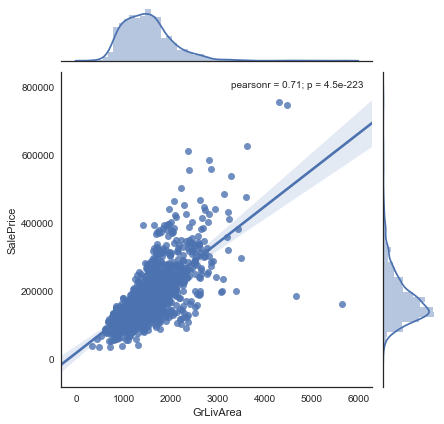

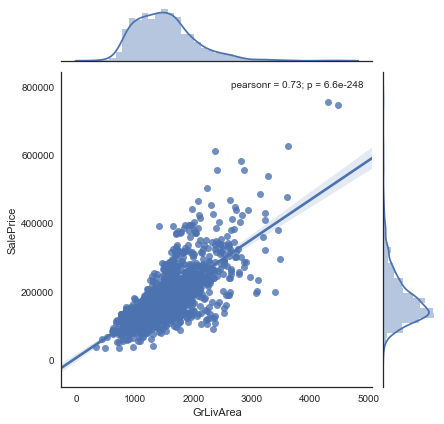

In [6]:
g = sns.jointplot(x = housetrain['GrLivArea'], y = housetrain['SalePrice'],kind="reg")
housetrain = housetrain.drop(housetrain[(housetrain['GrLivArea']>4000) & (housetrain['SalePrice']<300000)].index).reset_index(drop=True)
g = sns.jointplot(x = housetrain['GrLivArea'], y = housetrain['SalePrice'],kind="reg")
#jointplot utilized to visualize the GrLivArea against SalePrice to eliminate the outliers which consequently resulted in an increase 
#in pearson r coefficient.

In [ ]:
#The same process has been carried out for other attributes like OverallQual, TotalBsmtSF, GarageArea, GarageCars

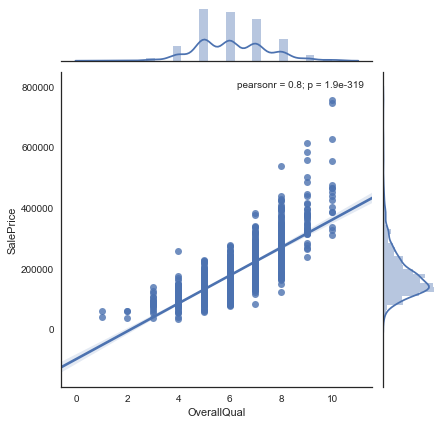

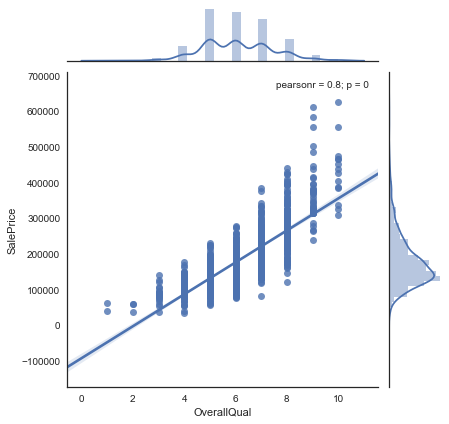

In [7]:
g = sns.jointplot(x = housetrain['OverallQual'], y = housetrain['SalePrice'],kind="reg")
print g
#here we can clearly observe that there are a few outliers in some categories and in order that they don't affect our analysis,
#we would remove them
housetrain = housetrain.drop(housetrain[(housetrain['OverallQual']==4) & (housetrain['SalePrice']>200000)].index).reset_index(drop=True)
housetrain = housetrain.drop(housetrain[(housetrain['OverallQual']==8) & (housetrain['SalePrice']>500000)].index).reset_index(drop=True)
housetrain = housetrain.drop(housetrain[(housetrain['OverallQual']==10) & (housetrain['SalePrice']>650000)].index).reset_index(drop=True)
g = sns.jointplot(x = housetrain['OverallQual'], y = housetrain['SalePrice'],kind="reg")

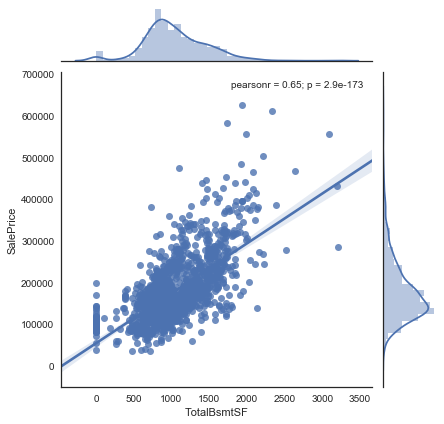

In [8]:
g = sns.jointplot(x = housetrain['TotalBsmtSF'], y = housetrain['SalePrice'],kind="reg")

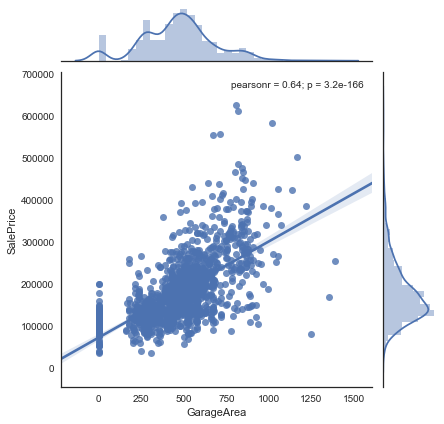

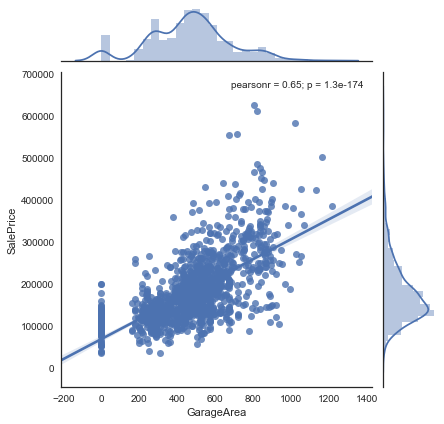

In [9]:
g = sns.jointplot(x = housetrain['GarageArea'], y = housetrain['SalePrice'],kind="reg")
housetrain = housetrain.drop(housetrain[(housetrain['GarageArea']>1200) & (housetrain['SalePrice']<300000)].index).reset_index(drop=True)
g = sns.jointplot(x = housetrain['GarageArea'], y = housetrain['SalePrice'],kind="reg")

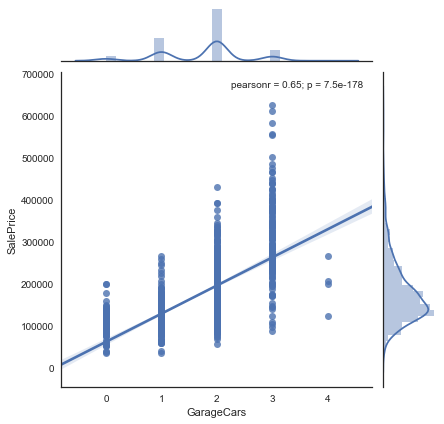

In [10]:
g = sns.jointplot(x = housetrain['GarageCars'], y = housetrain['SalePrice'],kind="reg")

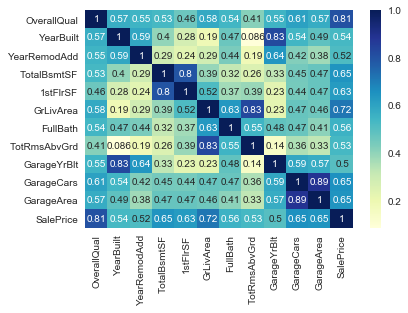

In [11]:
corrmat = housetrain.corr()
top_corr_features = corrmat.index[abs(corrmat["SalePrice"])>0.5]
g = sns.heatmap(housetrain[top_corr_features].corr(),annot=True,cmap="YlGnBu")
#created a heatmap here in order to visualizze the correlations between different attributes

In [12]:
def multiplot(data,features,plottype,nrows,ncols,figsize,y=None,colorize=False):
    """ This function draw a multi plot for 3 types of plots ["regplot","distplot","coutplot"]"""
    n = 0
    plt.figure(1)
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    
    if colorize:
        colors = sns.color_palette(n_colors=(nrows*ncols))
    else :
        colors = [None]*(nrows*ncols)
        
    for row in range(ncols):
        for col in range(nrows):
            
            if plottype == 'regplot':
                if y == None:
                    raise ValueError('y value is needed with regplot type')
                
                sns.regplot(data = data, x = features[n], y = y ,ax=axes[row,col], color = colors[n])
                correlation = np.corrcoef(data[features[n]],data[y])[0,1]
                axes[row,col].set_title("Correlation {:.2f}".format(correlation))
            
            elif plottype == 'distplot':
                sns.distplot(a = data[features[n]],ax = axes[row,col],color=colors[n])
                skewness = data[features[n]].skew()
                axes[row,col].legend(["Skew : {:.2f}".format(skewness)])
            
            elif plottype in ['countplot']:
                g = sns.countplot(x = data[features[n]], y = y, ax = axes[row,col],color = colors[n])
                g = plt.setp(g.get_xticklabels(), rotation=45)
                
            n += 1
    plt.tight_layout()
    plt.show()
    plt.gcf().clear()
#this function has been created to create plots of different types with specified number of rows and columns    

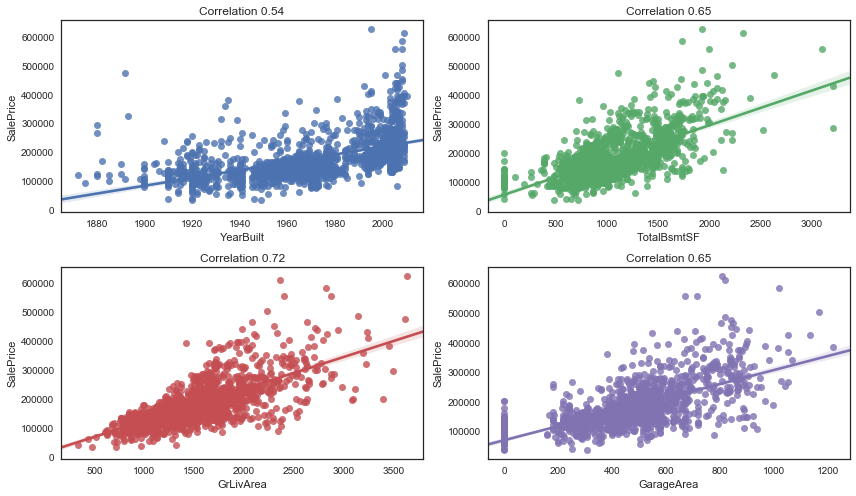

In [13]:
feats = ["YearBuilt","TotalBsmtSF","GrLivArea","GarageArea"]

plt.figure(1)
fig, axes = plt.subplots(2, 2, figsize=(12, 7))
colors = sns.color_palette(n_colors=(2*2))
n=0
for row in range(2):
        for col in range(2):
            sns.regplot(data = housetrain, x = feats[n], y = 'SalePrice' ,ax=axes[row,col], color = colors[n])
            correlation = np.corrcoef(housetrain[feats[n]],housetrain['SalePrice'])[0,1]
            axes[row,col].set_title("Correlation {:.2f}".format(correlation))
            n+=1
plt.tight_layout()
plt.show()
#Here we have defined a function in order to plot a regression plot for four intuitively important and highly correlated
#attributes with our target variable. After plotting we find out that we were actually correct, we can see that from the values of the
#correlation and thatb these features have relatively linear realtion with the target variable.


DATA CLEANING

In [14]:
train_len = len(housetrain)
#combine the train and test datasets to clean the data
dataset =  pd.concat(objs=[housetrain, housetest], axis=0).reset_index(drop=True)
dataset = dataset.fillna(np.nan)
#find the features with missing values
missing_features = dataset.columns[dataset.isnull().any()]
print missing_features
#find the total number of values in each column
print dataset[missing_features].isnull().sum()
dataset = dataset.fillna(np.nan)

Index([u'Alley', u'BsmtCond', u'BsmtExposure', u'BsmtFinSF1', u'BsmtFinSF2',
       u'BsmtFinType1', u'BsmtFinType2', u'BsmtFullBath', u'BsmtHalfBath',
       u'BsmtQual', u'BsmtUnfSF', u'Electrical', u'Exterior1st',
       u'Exterior2nd', u'Fence', u'FireplaceQu', u'Functional', u'GarageArea',
       u'GarageCars', u'GarageCond', u'GarageFinish', u'GarageQual',
       u'GarageType', u'GarageYrBlt', u'KitchenQual', u'LotFrontage',
       u'MSZoning', u'MasVnrArea', u'MasVnrType', u'MiscFeature', u'PoolQC',
       u'SalePrice', u'SaleType', u'TotalBsmtSF', u'Utilities'],
      dtype='object')
Alley           2712
BsmtCond          82
BsmtExposure      82
BsmtFinSF1         1
BsmtFinSF2         1
BsmtFinType1      79
BsmtFinType2      80
BsmtFullBath       2
BsmtHalfBath       2
BsmtQual          81
BsmtUnfSF          1
Electrical         1
Exterior1st        1
Exterior2nd        1
Fence           2340
FireplaceQu     1419
Functional         2
GarageArea         1
GarageCars         1
Ga

In [15]:
dataset["Alley"] = dataset["Alley"].fillna("None")

dataset["MiscFeature"] = dataset["MiscFeature"].fillna("None")

dataset["Fence"] = dataset["Fence"].fillna("None")

dataset["PoolQC"] = dataset["PoolQC"].fillna("None")

dataset["FireplaceQu"] = dataset["FireplaceQu"].fillna("None")
#in all the above features, we can replace the "na" values with None as the na here means that the count of these utilities is
#zero/None

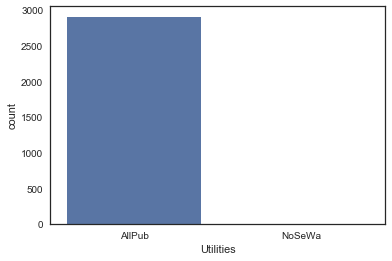

In [16]:
#Utilizing the countplot to find the majority value for the feature "Utilities" to replace all the missing values in that feature
#with
g = sns.countplot(dataset["Utilities"])

BASEMENT FEATURES

In [17]:
dataset["Utilities"] = dataset["Utilities"].fillna("AllPub")
dataset["BsmtCond"] = dataset["BsmtCond"].fillna("No")
dataset["BsmtQual"] = dataset["BsmtQual"].fillna("No")
dataset["BsmtFinType2"] = dataset["BsmtFinType2"].fillna("No")
dataset["BsmtFinType1"] = dataset["BsmtFinType1"].fillna("No")
dataset.loc[dataset["BsmtCond"] == "No","BsmtUnfSF"] = 0
dataset.loc[dataset["BsmtFinType1"] == "No","BsmtFinSF1"] = 0
dataset.loc[dataset["BsmtFinType2"] == "No","BsmtFinSF2"] = 0
dataset.loc[dataset["BsmtQual"] == "No","TotalBsmtSF"] = 0
dataset.loc[dataset["BsmtCond"] == "No","BsmtHalfBath"] = 0
dataset.loc[dataset["BsmtCond"] == "No","BsmtFullBath"] = 0
dataset["BsmtExposure"] = dataset["BsmtExposure"].fillna("No")


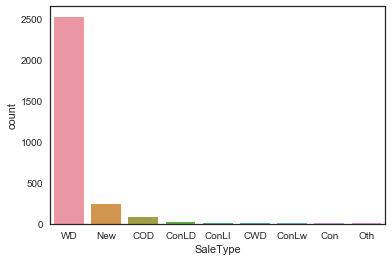

In [18]:
g = sns.countplot(dataset["SaleType"])
dataset["SaleType"] = dataset["SaleType"].fillna("WD")
#the same concept of countplot has been used to figure out the majority values for a few of the following attributes

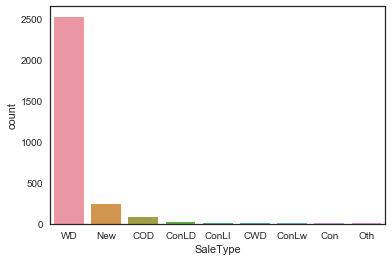

In [19]:
g = sns.countplot(dataset["SaleType"])

dataset["SaleType"] = dataset["SaleType"].fillna("WD")

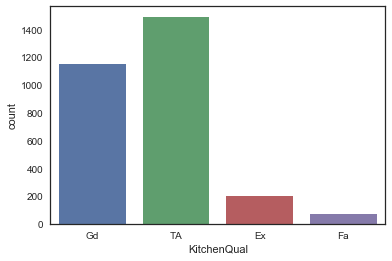

In [20]:
g = sns.countplot(dataset["KitchenQual"])

dataset["KitchenQual"] = dataset["KitchenQual"].fillna("TA")

GARAGE FEATURES

In [21]:
dataset["GarageType"] = dataset["GarageType"].fillna("No")
dataset["GarageFinish"] = dataset["GarageFinish"].fillna("No")
dataset["GarageQual"] = dataset["GarageQual"].fillna("No")
dataset["GarageCond"] = dataset["GarageCond"].fillna("No")
#Just used plain logical thinking here to figure out that if the "GarageType" is "No", then yrblt, cars area and any such numerical
#garage attributes would be valued at zero
dataset.loc[dataset["GarageType"] == "No","GarageYrBlt"] = dataset["YearBuilt"][dataset["GarageType"]=="No"]
dataset.loc[dataset["GarageType"] == "No","GarageCars"] = 0
dataset.loc[dataset["GarageType"] == "No","GarageArea"] = 0
#for the numerical garage attributes, we use the median imputation technique to fill in the missing values
dataset["GarageArea"] = dataset["GarageArea"].fillna(dataset["GarageArea"].median())
dataset["GarageCars"] = dataset["GarageCars"].fillna(dataset["GarageCars"].median())
dataset["GarageYrBlt"] = dataset["GarageYrBlt"].fillna(dataset["GarageYrBlt"].median())

UTILITIES

In [22]:
dataset["Functional"] = dataset["Functional"].fillna("Typ")
dataset["Exterior2nd"] = dataset["Exterior2nd"].fillna("VinylSd")
dataset["Exterior1st"] = dataset["Exterior1st"].fillna("VinylSd")
dataset["Electrical"] = dataset["Electrical"].fillna("SBrkr")
dataset["MasVnrType"] = dataset["MasVnrType"].fillna("None")
dataset.loc[dataset["MasVnrType"] == "None","MasVnrArea"] = 0
#same concept has been used to fill in the missing values in utilities features

ORDERED CATEGORICAL ATTRIBUTES

In [23]:
dataset = dataset.replace({'MSSubClass': {20: 'SubClass_20', 30: 'SubClass_30',40: 'SubClass_40',
45: 'SubClass_45',50: 'SubClass_50',60: 'SubClass_60',70: 'SubClass_70',
75: 'SubClass_75',80: 'SubClass_80',85: 'SubClass_85',90: 'SubClass_90',
120: 'SubClass_120',150: 'SubClass_150',160: 'SubClass_160',180: 'SubClass_180',
190: 'SubClass_190'}})
dataset = dataset.replace({'MoSold': {1: 'Jan', 2: 'Feb',3: 'Mar',
4: 'Apr',5: 'May',6: 'Jun',7: 'Jul',8: 'Aug',9: 'Sep',10: 'Oct',
11: 'Nov',12: 'Dec'}})
dataset['YrSold'] = dataset['YrSold'].astype(str)
#creating the categories for MSSubclass and MoSold fetaures and changing its type to a categorical attibute holding string values

In [24]:
dataset["BsmtCond"] = dataset["BsmtCond"].astype("category",categories=['No','Po','Fa','TA','Gd','Ex'],ordered=True).cat.codes
dataset["BsmtExposure"] = dataset["BsmtExposure"].astype("category",categories=['No','Mn','Av','Gd'],ordered=True).cat.codes
dataset["BsmtFinType1"] = dataset["BsmtFinType1"].astype("category",categories=['No','Unf','LwQ','Rec','BLQ','ALQ','GLQ'],ordered=True).cat.codes
dataset["BsmtFinType2"] = dataset["BsmtFinType2"].astype("category",categories=['No','Unf','LwQ','Rec','BLQ','ALQ','GLQ'],ordered=True).cat.codes
dataset["BsmtQual"] = dataset["BsmtQual"].astype("category",categories=['No','Po','Fa','TA','Gd','Ex'],ordered=True).cat.codes
dataset["ExterCond"] = dataset["ExterCond"].astype("category",categories=['Po','Fa','TA','Gd','Ex'],ordered=True).cat.codes
dataset["ExterQual"] = dataset["ExterQual"].astype("category",categories=['Po','Fa','TA','Gd','Ex'],ordered=True).cat.codes
dataset["Fence"] = dataset["Fence"].astype("category",categories=['No','MnWw','GdWo','MnPrv','GdPrv'],ordered=True).cat.codes
dataset["FireplaceQu"] = dataset["FireplaceQu"].astype("category",categories=['No','Po','Fa','TA','Gd','Ex'],ordered=True).cat.codes
dataset["Functional"] = dataset["Functional"].astype("category",categories=['Sal','Sev','Maj2','Maj1','Mod','Min2','Min1','Typ'],ordered=True).cat.codes
dataset["GarageCond"] = dataset["GarageCond"].astype("category",categories=['No','Po','Fa','TA','Gd','Ex'],ordered=True).cat.codes
dataset["GarageFinish"] = dataset["GarageFinish"].astype("category",categories=['No','Unf','RFn','Fin'],ordered=True).cat.codes
dataset["GarageQual"] = dataset["GarageQual"].astype("category",categories=['No','Po','Fa','TA','Gd','Ex'],ordered=True).cat.codes
dataset["HeatingQC"] = dataset["HeatingQC"].astype("category",categories=['Po','Fa','TA','Gd','Ex'],ordered=True).cat.codes
dataset["KitchenQual"] = dataset["KitchenQual"].astype("category",categories=['Po','Fa','TA','Gd','Ex'],ordered=True).cat.codes
dataset["PavedDrive"] = dataset["PavedDrive"].astype("category",categories=['N','P','Y'],ordered=True).cat.codes
dataset["PoolQC"] = dataset["PoolQC"].astype("category",categories=['No','Fa','TA','Gd','Ex'],ordered=True).cat.codes
dataset["Utilities"] = dataset["Utilities"].astype("category",categories=['ELO','NoSeWa','NoSewr','AllPub'],ordered=True).cat.codes
#rdered categorical features, for example this kernel is ("Very bad", "Bad", "okay", "Good", "Amazing") 
#need to be encoded as numerical ordered values (0->4 for example).

UNORDERED ATTRIBUTES

In [25]:
#Creating dummy predictors for unordered categorical attributes. 
dataset = pd.get_dummies(dataset,columns=["Alley","BldgType","CentralAir",
"Condition1","Condition2","Electrical","Exterior1st","Exterior2nd","Foundation",
"GarageType","Heating","HouseStyle","LandContour","LandSlope","LotConfig","LotShape",
"MSZoning","MasVnrType","MiscFeature","Neighborhood","RoofMatl","RoofStyle",
"SaleCondition","SaleType","Street","MSSubClass",'MoSold','YrSold'],drop_first=True)


In [26]:
skewed_features = ["BsmtFinSF1","BsmtFinSF2","BsmtUnfSF","GarageArea","MasVnrArea"
                   ,"TotalBsmtSF","1stFlrSF","2ndFlrSF","3SsnPorch","EnclosedPorch",
                   "GrLivArea","LotArea","LowQualFinSF","OpenPorchSF","PoolArea",
                   "ScreenPorch","WoodDeckSF"]

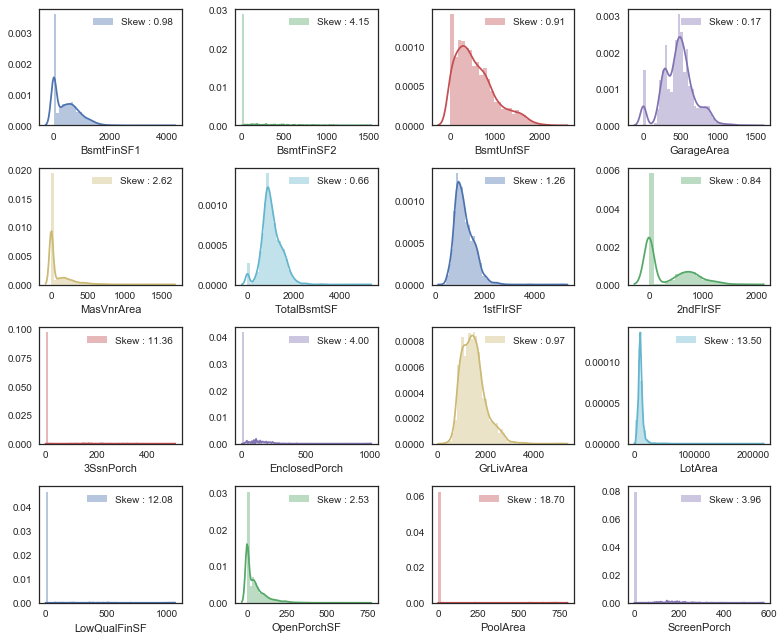

In [27]:
multiplot(data = dataset,features = skewed_features,plottype = "distplot",
          nrows = 4, ncols = 4, figsize = (11,9), colorize = True)


In [28]:
#most of the features in the above plot have positive skewness, we would employ the concept of log transformation to reduce 
#skewness
for feature in skewed_features:
    dataset[feature] = np.log1p(dataset[feature])

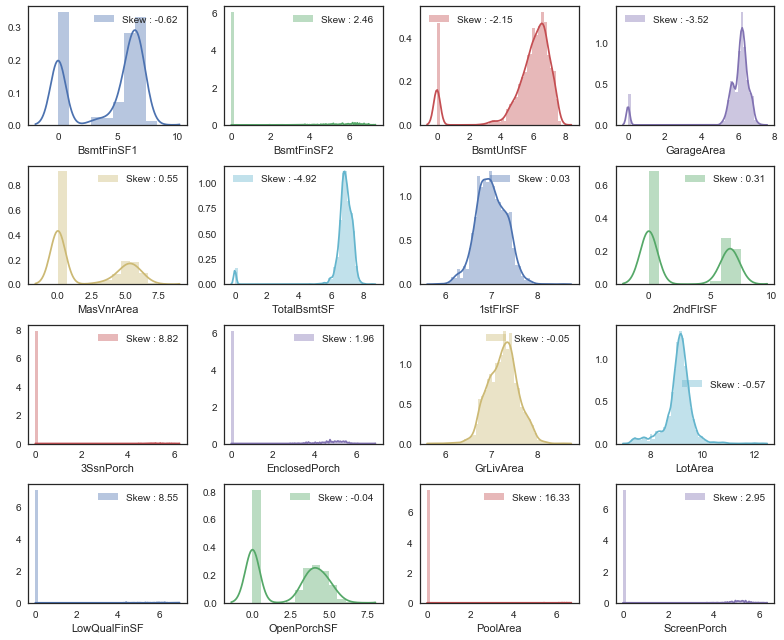

In [29]:
multiplot(data = dataset,features = skewed_features,plottype = "distplot",
          nrows = 4, ncols = 4, figsize = (11,9), colorize = True)
#Post removing the skewness by log transformation, we can clearly see that the skewness of these features has decreased by a lot.

I think the most important feature to focus on is the GrLivArea since it is strongly correlated with the SalePrice, and for this one the skew is almost 0.

I am sure that this transformation is not optimal, we could have select the most important skewed features and apply the most appropriate transformation. But i wanted to make it simple.

Nevertheless, the log transformation reduces significantly the rmse of the models.

Let's transform the target feature.

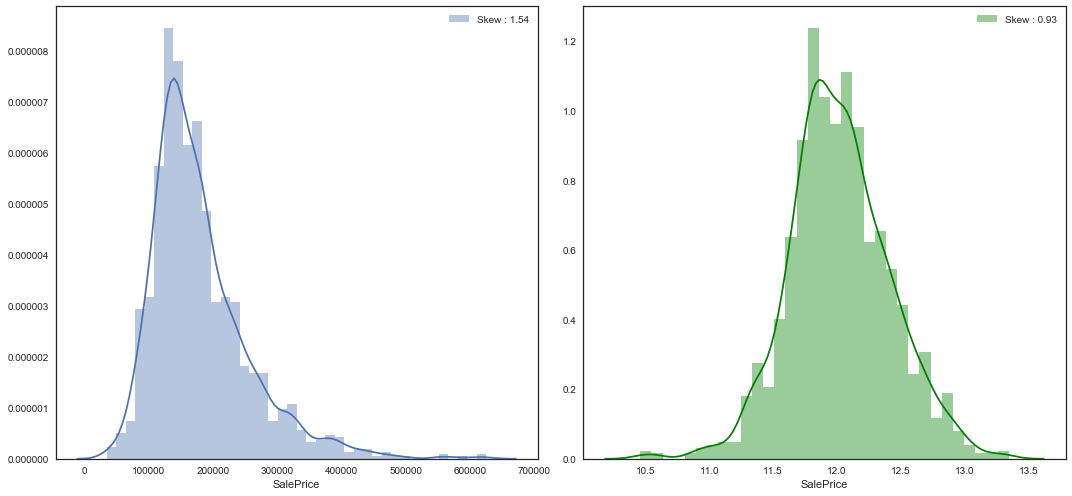

In [30]:
plt.figure(1)
fig, axes = plt.subplots(1,2,figsize=(15,7))

sns.distplot(housetrain["SalePrice"],ax = axes[0])
sns.distplot(np.log1p(housetrain["SalePrice"]),ax = axes[1],color="g")

axes[0].legend(["Skew : {:.2f}".format(housetrain["SalePrice"].skew())])
axes[1].legend(["Skew : {:.2f}".format(np.log1p(housetrain["SalePrice"].skew()))])

plt.tight_layout()
plt.show()
plt.gcf().clear()

In [31]:
dataset["SalePrice"] = np.log1p(dataset["SalePrice"])
Y = dataset["SalePrice"]
dataset = dataset.drop(labels="SalePrice",axis = 1)

In [32]:
features = dataset.columns

LotF = dataset["LotFrontage"]
dataset = dataset.drop(labels="LotFrontage",axis= 1)

Among the missing features, there is one(LotFrontage) that is difficult to manage. The LotFrontage feature has 486 missing values and i choose to predict them. But before i need to normalize the data.

NORMALISATION


In [33]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler
#N = RobustScaler()
#employin the min max scaler to noramlise the data
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(dataset)
df_normalized = pd.DataFrame(np_scaled)
df_normalized.head()

,0,1,2,3,4,5,6,7,8,9,...,220,221,222,223,224,225,226,227,228,229
0,0.345070,0.896567,0.0,0.375,0.75,0.000000,0.790791,0.0,1.000000,0.166667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.487537,0.000000,0.0,0.375,0.75,1.000000,0.830023,0.0,0.833333,0.166667,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.371528,0.898418,0.0,0.375,0.75,0.333333,0.745862,0.0,1.000000,0.166667,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,0.387529,0.880400,0.0,0.375,1.00,0.000000,0.648431,0.0,0.833333,0.166667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.451824,0.924356,0.0,0.500,0.75,0.666667,0.781767,0.0,1.000000,0.166667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Predicting the missing values for Lotfrontge using LassoCV modelling technique using the already known tuples

In [34]:
X_train_LotF = dataset[LotF.notnull()] 
Y_train_LotF = LotF[LotF.notnull()] # Get the LotFrontage non missing values
Y_train_LotF = np.log1p(Y_train_LotF) 
test_LotF = dataset[LotF.isnull()]

Here,below we find out the accuracy with which we would be able to predict the missing values for the Lotfrontage attribute.

In [35]:
lassocv = LassoCV(eps=1e-8)

cv_results = cross_val_score(lassocv,X_train_LotF,Y_train_LotF,cv=6,scoring="r2",n_jobs=4)
cv_results.mean()# approx0.76 ! 

0.764045569292268

In [36]:
lassocv.fit(X_train_LotF,Y_train_LotF)

LotF_pred = lassocv.predict(test_LotF)

LotF[LotF.isnull()] = LotF_pred

In [37]:
N = RobustScaler()
LotF = N.fit_transform(np.array(LotF).reshape(-1,1))

dataset = np.concatenate((dataset,LotF),axis = 1)
#using RobustScaler() to normalize the data after adding the mssing LotFronatge data

In [129]:
X_train = dataset[:train_len]
test = dataset[train_len:]
Y_train = Y[:train_len]
lassocv = LassoCV(eps=1e-7) 
ridge = Ridge(alpha=1e-6) 
lassolarscv = LassoLarsCV()
elasticnetcv = ElasticNetCV(eps=1e-15)
#here we split up the dataset into train and test again and then create objects of all the models we will be using 

In [130]:
def RMSE(estimator,X_train, Y_train, cv=5,n_jobs=4):
    cv_results = cross_val_score(estimator,X_train,Y_train,cv=cv,scoring="neg_mean_squared_error",n_jobs=n_jobs)
    return (np.sqrt(-cv_results)).mean()
#defining our own RMSE function to calculate the goodness of all the models

In [131]:
RMSE(lassocv, X_train, Y_train)

0.11487757992831504

In [133]:
from sklearn.model_selection import RandomizedSearchCV
alpha_space = np.logspace(-40, 8, 40)
param_grid = {'alpha': alpha_space}
#xtrain, xtest, ytrain, ytest = train_test_split(X_train, Y_train, test_size = 0.3, random_state = 42)
lasso = Lasso()
lasso_cv = RandomizedSearchCV(lasso, param_grid, cv=10, refit=True)
lasso_cv.fit(X_train, Y_train)
print("best parameter :{}".format(lasso_cv.best_params_))
#hyperparameter techinque of randomizedgridsearch to find out the best parameter

best parameter :{'alpha': 4.923882631706752e-05}


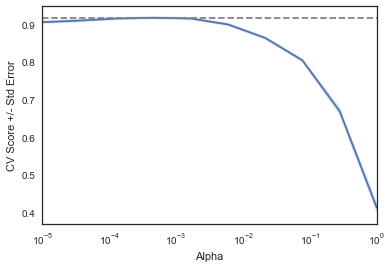

In [134]:


# Use grid search to tune the parameters:

#parametersGrid = {"max_iter": [1, 5, 10],
                     # "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                      #"l1_ratio": np.arange(0.0, 1.0, 0.1)}

enet = ElasticNet()
#grid = GridSearchCV(eNet, parametersGrid, cv=10)
#grid.fit(X_train, Y_train)
#Y_pred = grid.predict(X_test) 
#print("best parameter :{}".format(eNet.best_params_))
alpha_space = np.logspace(-5, 0, 10)
enet_scores = []
enet_scores_std = []

# Compute scores over range of alphas
for alpha in alpha_space:

    # Specify the alpha value to use: ridge.alpha
    enet.alpha = alpha
    
    enet_cv_scores = cross_val_score(enet, X_train, Y_train, cv=10)
    enet_scores.append(np.mean(enet_cv_scores))
    
    # Append the std of ridge_cv_scores to ridge_scores_std
    enet_scores_std.append(np.std(enet_cv_scores))

# Display the plot
display_plot(enet_scores, enet_scores_std)

In [135]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
xtrain, xtest, ytrain, ytest = train_test_split(X_train, Y_train, test_size = 0.3, random_state = 42)
lasso = Lasso(alpha=4.923882631706752e-05)
lasso.fit(xtrain, ytrain)
y_pred = lasso.predict(xtest)
rmse = np.sqrt(mean_squared_error(ytest, y_pred))
print ("RMSE:{}".format(rmse))

xtrain, xtest, ytrain, ytest = train_test_split(X_train, Y_train, test_size = 0.3, random_state = 42)
enet = ElasticNet(alpha=1e-3)
enet.fit(xtrain, ytrain)
y_pred = enet.predict(xtest)
rmse = np.sqrt(mean_squared_error(ytest, y_pred))
print ("RMSE:{}".format(rmse))

#computationally expensive
xtrain, xtest, ytrain, ytest = train_test_split(X_train, Y_train, test_size = 0.3, random_state = 42)
ecv = ElasticNetCV(eps=1e-15)
ecv.fit(xtrain, ytrain)
y_pred = ecv.predict(xtest)
rmse = np.sqrt(mean_squared_error(ytest, y_pred))
print ("RMSE:{}".format(rmse))

xtrain, xtest, ytrain, ytest = train_test_split(X_train, Y_train, test_size = 0.3, random_state = 42)
lcv = LassoLarsCV()
lcv.fit(xtrain, ytrain)
y_pred = lcv.predict(xtest)
rmse = np.sqrt(mean_squared_error(ytest, y_pred))
print ("RMSE:{}".format(rmse))

xtrain, xtest, ytrain, ytest = train_test_split(X_train, Y_train, test_size = 0.3, random_state = 42)
ridge = Ridge()
ridge.fit(xtrain, ytrain)
y_pred = ridge.predict(xtest)
rmse = np.sqrt(mean_squared_error(ytest, y_pred))
print ("RMSE:{}".format(rmse))
#finding out the RMSE scores on the test dataset that was created internally from the train dataset

RMSE:0.126890440009
RMSE:0.126097332353
RMSE:0.126734014318
RMSE:0.127955942061
RMSE:0.126498426452


In [47]:
lasso = Lasso(alpha=4.923882631706752e-05)
lasso.fit(X_train, Y_train)
y_pred = lasso.predict(test)
print len(y_pred)

1459




Ridge regression is used to reduce overfitting but includes all the features.

In [48]:
print RMSE(elasticnet, X_train, Y_train)
print RMSE(elasticnetcv, X_train, Y_train)
print RMSE(lassolarscv, X_train, Y_train)
print RMSE(ridge, X_train, Y_train)

0.11479165708490165
0.11502115470243612
0.11530600532173921
0.11877685131700044


In [49]:
def display_plot(cv_scores, cv_scores_std):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.plot(alpha_space, cv_scores)

    std_error = cv_scores_std / np.sqrt(10)

    ax.fill_between(alpha_space, cv_scores + std_error, cv_scores - std_error, alpha=0.2)
    ax.set_ylabel('CV Score +/- Std Error')
    ax.set_xlabel('Alpha')
    ax.axhline(np.max(cv_scores), linestyle='--', color='.5')
    ax.set_xlim([alpha_space[0], alpha_space[-1]])
    ax.set_xscale('log')
    plt.show()


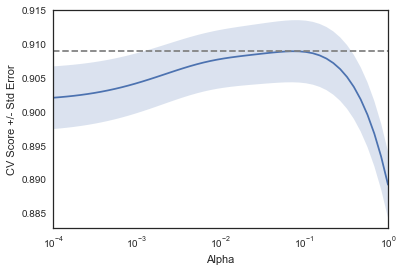

In [50]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

# Setup the array of alphas and lists to store scores
alpha_space = np.logspace(-4, 0, 50)
ridge_scores = []
ridge_scores_std = []

# Create a ridge regressor: ridge
ridge = Ridge(normalize=True)

# Compute scores over range of alphas
for alpha in alpha_space:

    # Specify the alpha value to use: ridge.alpha
    ridge.alpha = alpha
    
    # Perform 10-fold CV: ridge_cv_scores
    ridge_cv_scores = cross_val_score(ridge, X_train, Y_train, cv=10)
    ridge_scores.append(np.mean(ridge_cv_scores))
    
    # Append the std of ridge_cv_scores to ridge_scores_std
    ridge_scores_std.append(np.std(ridge_cv_scores))

# Display the plot
display_plot(ridge_scores, ridge_scores_std)

In [139]:
lassocv.fit(X_train,Y_train)
ridge.fit(X_train,Y_train)
lassolarscv.fit(X_train,Y_train)
elasticnetcv.fit(X_train,Y_train)
elasticnet.fit(X_train, Y_train)


ElasticNet(alpha=0.001, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [53]:
print("LassoCV regression has conserved %d features over %d"%(len(features[lassocv.coef_!=0]),X_train.shape[1]))
print("Ridge regression has conserved %d features over %d"%(len(features[ridge.coef_!=0]),X_train.shape[1]))
print("LassoLarsCV regression has conserved %d features over %d"%(len(features[lassolarscv.coef_!=0]) ,X_train.shape[1]))
print("ElasticNetCV regression has conserved %d features over %d"%(len(features[elasticnetcv.coef_!=0]),X_train.shape[1]))

LassoCV regression has conserved 75 features over 231
Ridge regression has conserved 230 features over 231
LassoLarsCV regression has conserved 63 features over 231
ElasticNetCV regression has conserved 94 features over 231


IndexError: list index out of range

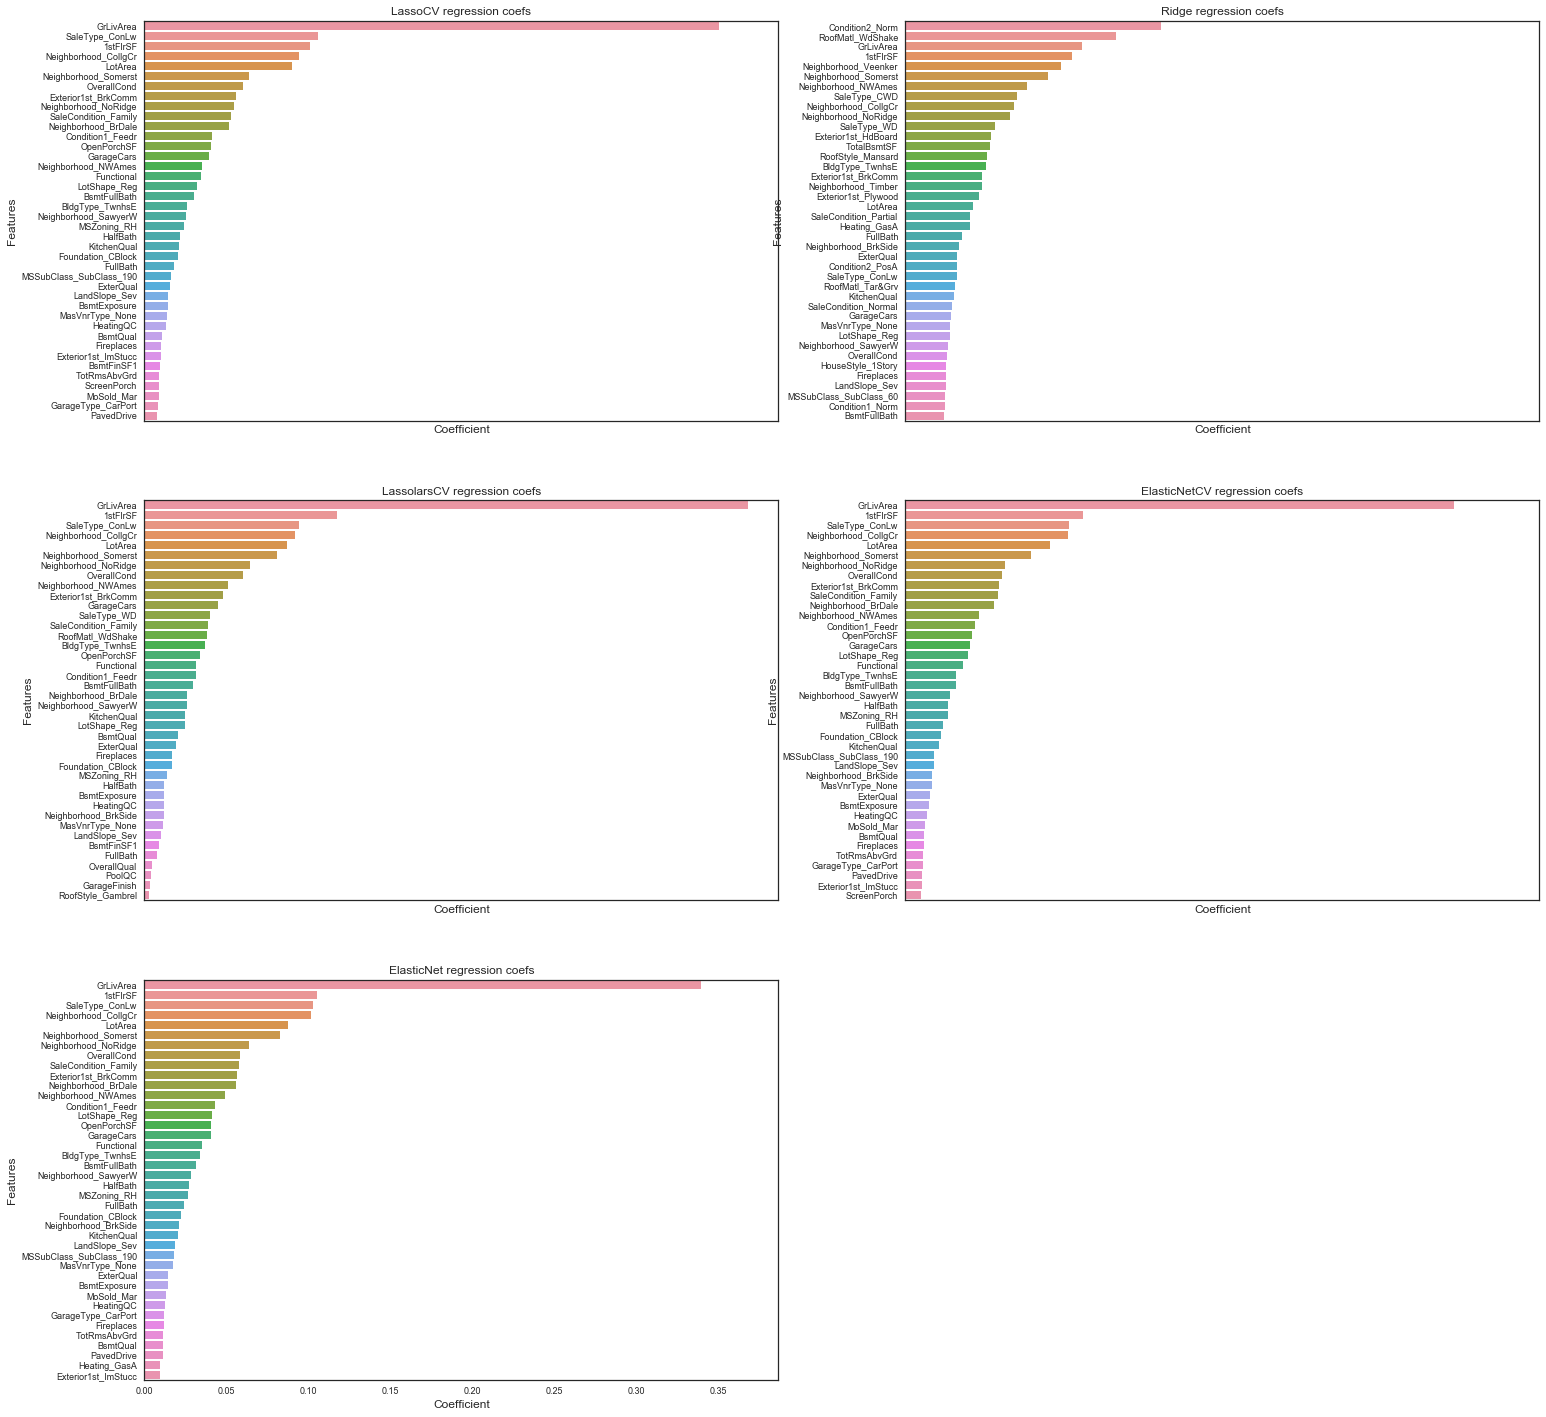

In [54]:
nrows = 3
ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex=True, figsize=(25,25))

names_regressors = [("LassoCV", lassocv),("Ridge",ridge),("LassolarsCV",lassolarscv),("ElasticNetCV",elasticnetcv), 
                    ("ElasticNet", elasticnet)]

nregressors = 0
for row in range(nrows):
    for col in range(ncols):
        if row == 2 and col == 1:
            plt.delaxes()
        name = names_regressors[nregressors][0]
        regressor = names_regressors[nregressors][1]
        indices = np.argsort(regressor.coef_)[::-1][:40]
        g = sns.barplot(y=features[indices][:40],x = regressor.coef_[indices][:40] , orient='h',ax=axes[row][col])
        g.set_xlabel("Coefficient",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " regression coefs")
        nregressors += 1
           
plt.tight_layout()
plt.show()
plt.gcf().clear()

In [136]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.2, gamma=0.0, 
                             learning_rate=0.05, max_depth=6, 
                             min_child_weight=1.5, n_estimators=7200,
                             reg_alpha=0.9, reg_lambda=0.6,
                             subsample=0.2,seed=42, silent=1)

RMSE(model_xgb,X_train,Y_train)
#defining the XGBRegressor object with tuned hyperparameters to make predictions

0.1193531516221696

In [63]:
model_adr = AdaBoostRegressor(learning_rate = 0.39, loss= 'exponential', n_estimators =100)
RMSE(model_adr, X_train, Y_train) #very bad!

0.16366419934086468

In [58]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
 'n_estimators': [50, 100],
 'learning_rate' : [0.01,0.05,0.1,0.3,1],
 'loss' : ['linear', 'square', 'exponential']
 }

pre_gs_inst = RandomizedSearchCV(AdaBoostRegressor(),
 param_distributions = param_dist,
 cv=3,
 n_iter = 10,
 n_jobs=-1)

pre_gs_inst.fit(X_train, Y_train)
pre_gs_inst.best_params_

{'learning_rate': 0.3, 'loss': 'exponential', 'n_estimators': 100}

In [61]:
param_dist = {
 'n_estimators': [60, 80, 100, 120],
 'learning_rate' : [0.21,0.23,0.25,0.27,0.29, 0.31, 0.33, 0.35, 0.37, 0.39, 0.41, 0.45],
 'loss' : ['linear', 'square', 'exponential']
 }

pre_gs_inst = RandomizedSearchCV(AdaBoostRegressor(),
 param_distributions = param_dist,
 cv=5,
 n_iter = 10,
 n_jobs=-1)

pre_gs_inst.fit(X_train, Y_train)
pre_gs_inst.best_params_

{'learning_rate': 0.39, 'loss': 'exponential', 'n_estimators': 60}

In [141]:
Y_pred_lassocv = np.expm1(lassocv.predict(test))
print Y_pred_lassocv
Y_pred_lassolarscv = np.expm1(lassolarscv.predict(test))
print Y_pred_lassolarscv
Y_pred_elasticnetcv = np.expm1(elasticnetcv.predict(test))
print Y_pred_elasticnetcv
model_xgb.fit(X_train,Y_train)
Y_pred_xgb = np.expm1(model_xgb.predict(test))
print Y_pred_xgb
basic_ensemble = Y_pred_lassocv*0.4 + Y_pred_elasticnetcv*0.3 + Y_pred_xgb*0.3
print basic_ensemble

[113261.65529125 156139.93236161 177601.55227686 ... 167071.55297667
 123159.38012742 233868.59046023]
[113373.03660336 157287.7534037  178078.42584409 ... 163310.09529341
 123928.04156796 227137.92154413]
[112732.08200741 156592.40226687 176704.62779506 ... 166421.85793807
 122752.23775585 232337.56576716]
[121802.34 160141.45 184019.2  ... 165483.22 110608.68 207385.03]
[115664.98984372 157476.13112471 179257.77096801 ... 166400.14732209
 119272.02884647 225464.21763299]


In [149]:
print type(basic_ensemble)
ensemble = pd.DataFrame(basic_ensemble)
print len(ensemble)


<type 'numpy.ndarray'>
1459


In [75]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [ ]:
submissions = pd.read_csv('C:/Data Mining/final project/sample_submission.csv')
submissions['SalePrice'] = basic_ensemble
submissions.to_csv("C:/Data Mining/final project/results.csv",index=False)